In [ ]:
import math
from enum import Enum
from typing import List
import random

In [ ]:
class TypeActivation(Enum):
  stepFunction = 0
  logisticSigmoid = 1
  hyperbolicTangent = 2
  softmax = 3

In [ ]:
class TypeError(Enum):
  squareError = 0
  crossEntropy = 1

In [ ]:
class Perceptron(object):

  #0 step function, 1 logistic sigmoid, 2 hyperbolic tangent
  def __init__(self, activation: TypeActivation, inputWeights):
    self.__activation = activation
    self.__inWeights = []
    for i in range(inputWeights + 1):
      self.__inWeights.append(random.gauss(0, 1))

  def getActivation(self):
    return self.__activation

  def getInWeights(self):
    return self.__inWeights

  def setInWeights(self, w):
    self.__inWeights = w.copy()

  #outVec is used only when we have the softmax
  def output(self, x, outVec = []):
    #the softmax require two call, one for calculating the output without applayng the softmax and one applaying the softmax
    if not outVec:
      sum = 0
      for i in range(len(self.__inWeights)-1):
        sum +=  self.__inWeights[i]*x[i]
      out = self.__activationFunction(sum+self.__inWeights[-1])
    else:
      out = self.__activationFunction(x, outVec)
    return out

  def __activationFunction(self, u, softmaxIn = []):
    match self.__activation.value:
      case TypeActivation.stepFunction.value:
        return 1 if u>=0 else 0
      case TypeActivation.logisticSigmoid.value:
        return 1/(1 + math.exp(-u))
      case TypeActivation.hyperbolicTangent.value:
        return (math.exp(u) - math.exp(-u))/(math.exp(u) + math.exp(-u))
      case TypeActivation.softmax.value:
        if not softmaxIn:
          return u
        else:
          normalizer = 0
          for i in softmaxIn:
            normalizer += math.exp(i)
          return math.exp(u)/normalizer

In [ ]:
class Model(object):

  def __init__(self, inputDim, activations: List[TypeActivation], neuronsLayer: List[int], errorFun: TypeError):
    self.__layers = len(neuronsLayer)
    self.__neuronsLayer = neuronsLayer
    self.__network = []
    self.__errorType = errorFun
    numNeurons = 0
    for i in range(self.__layers):
      layer = []
      for _ in range(neuronsLayer[i]):
        layer.append(Perceptron(activations[i], inputDim if i==0 else self.__neuronsLayer[i-1]))
      self.__network.append(layer)

  def fit(self, X, y, learningRate, epochs):
    errors = []
    for _ in range(epochs):
      predictions = []
      for i in range(len(X)):
        prediction, actOut = self.predict(X[i])
        predictions.append(prediction)
        self.__backpropagation(actOut, X[i], y[i], learningRate)
      errors.append(self.__error(predictions, y))
    return errors
    #self.__weight = [[0]*(self.__neuronsLayer[0] * len(X[0]))]
    #for i in range(self.__layers - 1):
      #self.__weight.append([0] * (self.__neuronsLayer[i]*self.__neuronsLayer[i+1]))

  def __error(self, y, t):
    err = 0
    print("Target", t)
    print("Predict", y)
    match(self.__errorType.value):
      case TypeError.squareError.value:
        for i in range(len(y)):
          for j in range(len(y[i])):
            err += (y[i][j] - t[i][j])**2
        return err * (1/2)
      case TypeError.crossEntropy.value:
        for i in range(len(y)):
          for j in range(len(y[i])):
            err += (t[i][j] + 1e-10)*math.log(y[i][j] + 1e-10)
        return -err

  def __backpropagation(self, actOut, x, y, learningRate):
    #partial derivative DEn/Daj for each neuron
    theta = []
    for i in range(self.__layers-1, -1, -1):
      rowTheta = []
      for j in range(self.__neuronsLayer[i]):
        th = 0
        #if output layer
        if(i == self.__layers-1):
          th = (actOut[i][j]) - (y[j])
        #if hidden layer
        else:
          #th_j = h'(a_j)*sum k=1 ...neuronsNextLayer (w_kj*th_k)
          for k in range(self.__neuronsLayer[i+1]):
            wk = self.__network[i+1][k].getInWeights()
            th += wk[j] * theta[0][k]
          #calculate derivative of the activation function (h'(a_j))
          if(self.__network[i][j].getActivation().value == TypeActivation.hyperbolicTangent.value):
            th *= (1 - (actOut[i][j])**2)
          elif(self.__network[i][j].getActivation().value == TypeActivation.logisticSigmoid.value or self.__network[i][j].getActivation().value == TypeActivation.softmax.value):
            th *= (actOut[i][j] * (1 - actOut[i][j]))
        rowTheta.append(th)
        #calculate derivativ of the error respect any wights of the neurons ij
        weightsDerivativ = []
        #if the layer is not the first
        if(i != 0):
          for k in range(self.__neuronsLayer[i-1]):
            weightsDerivativ.append(th*actOut[i-1][k])
        else:
          for k in range(len(x)):
            weightsDerivativ.append(th*x[k])
        #bias output = 1
        weightsDerivativ.append(th)
        #applay gradient descent
        newWeights = self.__gradientDescent(self.__network[i][j].getInWeights(), weightsDerivativ, learningRate)
        print("OldWeights", self.__network[i][j].getInWeights())
        print('NewWeights', newWeights)
        self.__network[i][j].setInWeights(newWeights)
      theta.insert(0, rowTheta)


  def __gradientDescent(self, wi, wiDerivativ, learningRate):
    wj = []
    for i in range(len(wi)):
       wj.append(wi[i] + (-learningRate*wiDerivativ[i]))
    return wj

  def predict(self, x):
    actOut = []
    for i in range(self.__layers):
      row = []
      for j in range(self.__neuronsLayer[i]):
        if(i == 0):
          row.append(self.__network[i][j].output(x))
        else:
          row.append(self.__network[i][j].output(actOut[i-1]))
      actOut.append(row)

    #if the softmax we have to applay the softmax to the output w*z
    if(self.__network[-1][0].getActivation().value == TypeActivation.softmax.value):
      row = []
      for i in range(self.__neuronsLayer[-1]):
        row.append(self.__network[-1][i].output(actOut[-1][i], actOut[-1]))
      actOut[-1] = row

    #calculate the binary vector output
    output = []
    if(len(actOut[-1]) > 1):
      maxAct = max(actOut[-1])
      for activation in actOut[-1]:
        if activation == maxAct:
          output.append(1)
        else:
          output.append(0)
    else:
      act = self.__network[-1][0].getActivation().value
      if(act == TypeActivation.logisticSigmoid.value):
        output.append(1 if  actOut[-1][0]>= 0.5 else 0)
      elif(act == TypeActivation.hyperbolicTangent.value):
        output.append(1 if  actOut[-1][0]>= 0 else -1)
      elif(act == TypeActivation.stepFunction.value):
        output.append(1 if  actOut[-1][0]>= 0 else 0)

    print("Activation", actOut)
    return output, actOut

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imoport the Iris Dataset considering only two feautures

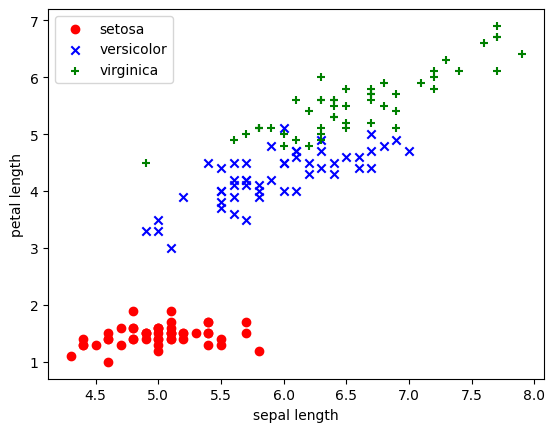

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()
y = df.iloc[0:150, 4].values
X = df.iloc[0:150, [0, 2]].values
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.scatter(X[100:150, 0], X[100:150, 1], color='green', marker='+', label='virginica')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.legend(loc='upper left')
plt.show()

## First Non Linear Multilayer-Network with 2 layers and using the Square Error



In [ ]:
ppn = Model(X.shape[1], [TypeActivation.logisticSigmoid, TypeActivation.softmax], [5, 3], TypeError.squareError)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Crea un'istanza dell'encoder
encoder = OneHotEncoder()

# Addestra l'encoder e applica la hot encoding al target y
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
print(y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

In [ ]:
# @title
errors = ppn.fit(X, y, 0.01, 15)

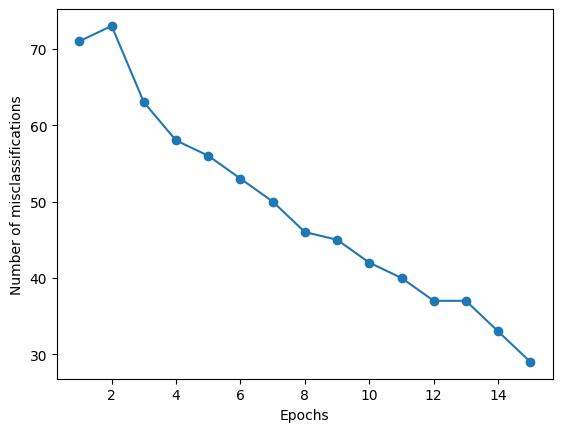

In [ ]:
plt.plot(range(1, len(errors) + 1), errors,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.show()

## Second Non Linear Multilayer-Network with 2 layers and using the Cross Entropy




In [ ]:
ppn = Model(X.shape[1], [TypeActivation.hyperbolicTangent, TypeActivation.softmax], [10, 3], TypeError.crossEntropy)

In [ ]:
errors = ppn.fit(X, y, 0.01, 15)

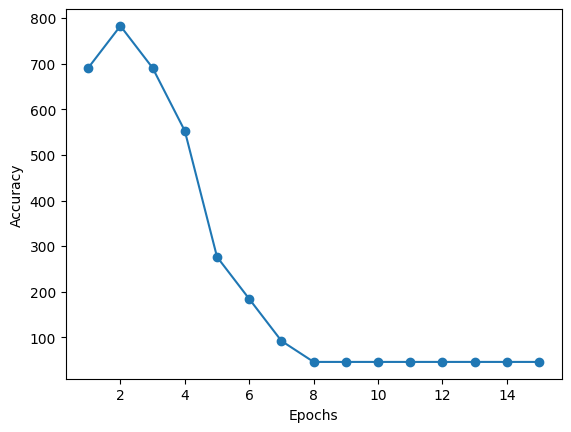

In [ ]:
plt.plot(range(1, len(errors) + 1), errors,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Discrepancy')
plt.show()

## Third Non Linear Multilayer-Network with 3 layers and using the Cross Entropy




In [ ]:
ppn = Model(X.shape[1], [TypeActivation.hyperbolicTangent, TypeActivation.hyperbolicTangent, TypeActivation.softmax], [10,10,3], TypeError.crossEntropy)

In [ ]:
errors = ppn.fit(X, y, 0.01, 15)

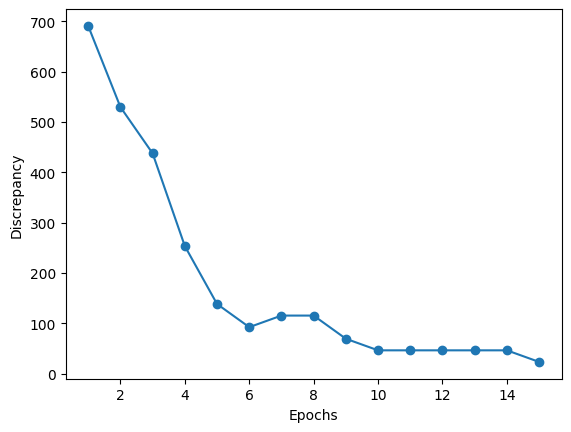

In [ ]:
plt.plot(range(1, len(errors) + 1), errors,marker='o')
plt.xlabel('Epochs')
plt.ylabel('Discrepancy')
plt.show()

# Import the Iris Dataset considering all the feautures


In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()
y = df.iloc[0:150, 4].values
X = df.iloc[0:150, 0:3].values

## Let’s see if we can apply a dimensionality reduction without information loss

In [ ]:
np.linalg.matrix_rank(X)

3

## Applay the PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

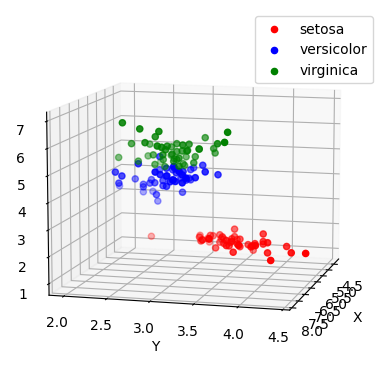

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X_coord = X[:, 0]
Y_coord = X[:, 1]
Z_coord = X[:, 2]

X_group1 = X_coord[:50]
Y_group1 = Y_coord[:50]
Z_group1 = Z_coord[:50]

X_group2 = X_coord[50:100]
Y_group2 = Y_coord[50:100]
Z_group2 = Z_coord[50:100]

X_group3 = X_coord[100:]
Y_group3 = Y_coord[100:]
Z_group3 = Z_coord[100:]

ax.scatter(X_group1, Y_group1, Z_group1, color='red', label='setosa')
ax.scatter(X_group2, Y_group2, Z_group2, color='blue', label='versicolor')
ax.scatter(X_group3, Y_group3, Z_group3, color='green', label='virginica')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#set angolation
ax.view_init(elev=10, azim=15)

plt.legend()


plt.show()

## Analyzing the variance of the components

In [ ]:
pca.explained_variance_ratio_

array([0.92466345, 0.0604435 , 0.01489304])

In [ ]:
pca = PCA(n_components=1)
X_reduced = pca.fit_transform(X)

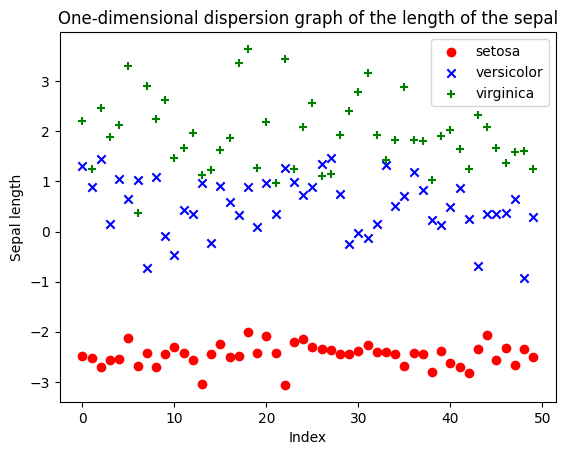

In [ ]:
plt.scatter(range(50), X_reduced[0:50], color='red', marker='o', label='setosa')
plt.scatter(range(50), X_reduced[50:100], color='blue', marker='x', label='versicolor')
plt.scatter(range(50), X_reduced[100:150], color='green', marker='+', label='virginica')
plt.title('One-dimensional dispersion graph of the length of the sepal')
plt.xlabel("Index")
plt.ylabel("Sepal length")
plt.legend()
plt.show()

## We can applay a classification using intervals

(array([1., 0., 0., 0., 0., 0., 0., 1., 1., 3., 5., 1., 1., 2., 1., 5., 0.,
        3., 3., 3., 1., 3., 2., 2., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 1.]),
 array([0.36048391, 0.44256123, 0.52463855, 0.60671587, 0.68879319,
        0.77087051, 0.85294782, 0.93502514, 1.01710246, 1.09917978,
        1.1812571 , 1.26333442, 1.34541174, 1.42748906, 1.50956638,
        1.5916437 , 1.67372102, 1.75579834, 1.83787565, 1.91995297,
        2.00203029, 2.08410761, 2.16618493, 2.24826225, 2.33033957,
        2.41241689, 2.49449421, 2.57657153, 2.65864885, 2.74072617,
        2.82280349, 2.9048808 , 2.98695812, 3.06903544, 3.15111276,
        3.23319008, 3.3152674 , 3.39734472, 3.47942204, 3.56149936,
        3.64357668]),
 <BarContainer object of 40 artists>)

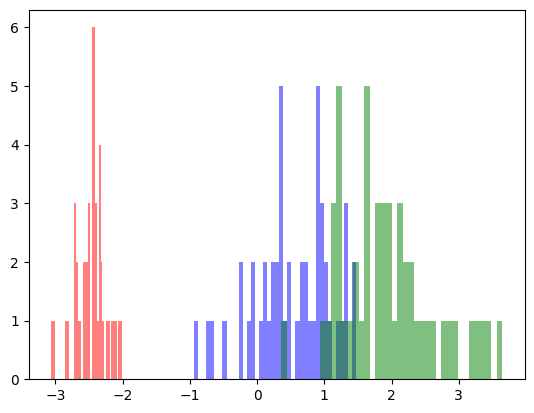

In [ ]:
plt.hist(X_reduced[0:50], bins=40, color='red', alpha=0.5, label='setosa')
plt.hist(X_reduced[50:100], bins=40, color='blue', alpha=0.5, label='versicolor')
plt.hist(X_reduced[100:150], bins=40, color='green', alpha=0.5, label='virginica')

In [ ]:
predictions = []
for i in X_reduced:
  if(i <= -1.5):
    predictions.append([1, 0, 0])
  elif(i <= 1.1):
    predictions.append([0, 1, 0])
  else:
    predictions.append([0, 0, 1])

def valuation(predictions, target):
  misclassification = 0
  for i in range(len(predictions)):
    for j in range(3):
      if(predictions[i][j] != target[i][j]):
        misclassification += 1
        j = 3
  return misclassification

print(valuation(predictions, y))

20


## Let's see the difference with a K-Nearest Neighbors classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_reduced, y)
print(valuation(knn.predict(X_reduced), y))

18
